Replicate paper

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
class SpotRateModel:
    def __init__(self,
                 r0,
                 a,
                 b,
                 theta,
                 sigma,
                 lamda,
                 gamma,
                 mu,
                 h,
                 t,
                 T,
                 m,
                 model_name):
        self.r0 = r0
        self.a = a
        self.b = b
        self.theta = theta
        self.sigma = sigma
        self.lamda = lamda
        self.gamma = gamma
        self.mu = mu
        self.h = h
        self.t = t
        self.T = T
        self.m = m
        self.delta_t = 1/m
        self.model_name = model_name
        
    def get_spot_rates(self):
        prev_spot_rate = self.r0
        self.spot_rates = []
        for i in range(self.m*(self.T-self.t)):
                if i==0:
                    self.spot_rates.append(prev_spot_rate)
                else:
                    prev_spot_rate = self.spot_rates[i-1]
                    if self.model_name == "vasicek":
                        self.spot_rates.append(prev_spot_rate + (self.theta - self.a*prev_spot_rate - self.lamda*self.sigma)*self.delta_t + self.sigma*np.random.normal()*np.sqrt(self.delta_t) + np.random.normal(self.mu, self.gamma)*np.random.poisson(self.h*self.delta_t))
                    if self.model_name == "cir":
                        sr = prev_spot_rate + (self.theta - self.a*prev_spot_rate - self.lamda*self.sigma*np.sqrt(prev_spot_rate))*self.delta_t + self.sigma*np.sqrt(prev_spot_rate)*np.random.normal()*np.sqrt(self.delta_t) + np.random.normal(self.mu, self.gamma)*np.random.poisson(self.h*self.delta_t)
                        if sr < 0:
                            sr = 0
                        self.spot_rates.append(sr)
        return pd.DataFrame(self.spot_rates, index=np.arange(self.m*(self.T-self.t)))
            

            

In [3]:
class MonteCarloSimulation:
    def __init__(self, 
                 num_simulations,
                 spot_rate_model):
        self.num_simulations = num_simulations
        self.spot_rate_model = spot_rate_model

    def simulate(self):
        
        spot_rates = pd.DataFrame(index=np.arange((self.spot_rate_model.T-self.spot_rate_model.t)*self.spot_rate_model.m))
        spot_rates_cumsum = pd.DataFrame(index=np.arange(self.spot_rate_model.T-self.spot_rate_model.t))
        
        for i in range(self.num_simulations):
            spot_rates[i] = self.spot_rate_model.get_spot_rates()
            df = pd.DataFrame(np.reshape(spot_rates[i].values, (self.spot_rate_model.m, self.spot_rate_model.T-self.spot_rate_model.t)))
            spot_rates_cumsum[i] = df.sum().cumsum().values
        
        bond_prices = spot_rates_cumsum.copy()
        for i in range(self.num_simulations):
            bond_prices[i] = np.exp(-bond_prices[i]*self.spot_rate_model.delta_t)
            
        bond_prices = bond_prices.mean(axis=1)
        bond_prices = pd.concat([pd.Series([1.0]), bond_prices], ignore_index=True)
        
        return spot_rates, bond_prices
    

In [4]:
vasicek = SpotRateModel(r0=0.05,
                 a=0.5,
                 b=0.05,
                 theta=0.025,
                 sigma=0.08,
                 lamda=-0.5,
                 gamma=0.01,
                 mu=0,
                 h=10,
                 t=0,
                 T=20,
                 m=365,
                 model_name='vasicek')

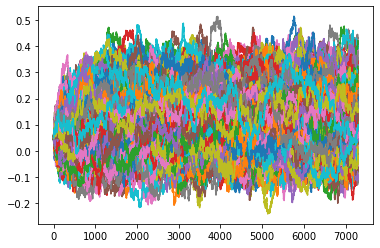

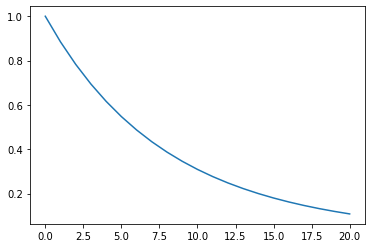

In [5]:
mc_vasicek = MonteCarloSimulation(1000, vasicek)
sr_vasicek, bp_vasicek = mc_vasicek.simulate()
sr_vasicek.plot(legend=False)
plt.show()
bp_vasicek.plot()
plt.show()

In [6]:
cir = SpotRateModel(r0=0.05,
                 a=0.5,
                 b=0.05,
                 theta=0.025,
                 sigma=0.08,
                 lamda=-0.5,
                 gamma=0.01,
                 mu=0,
                 h=10,
                 t=0,
                 T=20,
                 m=365,
                 model_name='cir')

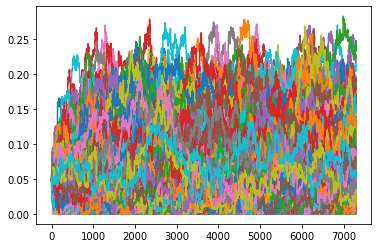

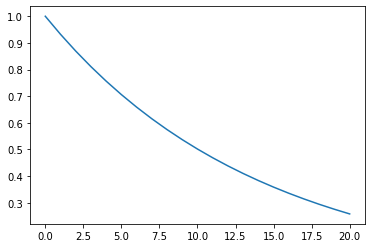

In [7]:
mc_cir = MonteCarloSimulation(1000, cir)
sr_cir, bp_cir = mc_cir.simulate()
sr_cir.plot(legend=False)
plt.show()
bp_cir.plot()
plt.show()

In [8]:
bp = pd.DataFrame(index=np.arange(1, 21))
bp['CIR'] = bp_cir
bp['VASICEK'] = bp_vasicek

<AxesSubplot:>

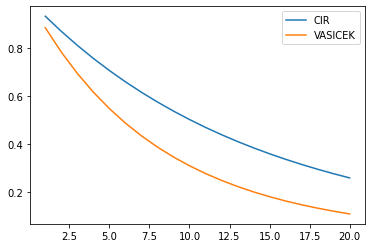

In [9]:
bp.plot(legend=True)